# 01. Load packages

In [ ]:
import torch 
import tensorflow as tf
from tqdm import tqdm

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

device = torch.device('cuda:0')

 


2022-08-04 02:45:19.013473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 02:45:19.019935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 02:45:19.020597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


#### for multi GPU environment,

In [ ]:
import torch 
import tensorflow as tf
from tqdm import tqdm

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[3],'GPU')
tf.config.experimental.set_memory_growth(gpus[3],True)

device = torch.device('cuda:3')

# 02. Test simple add function 

In [ ]:
def add(a,b):
    return a+b

@tf.function
def tf_add(a,b):
    return a+b

def torch_add(a,b):
    return torch.tensor(a+b, device = device)

In [ ]:
tf_value = tf_add(1,2)

2022-08-04 02:45:19.058308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 02:45:19.058972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 02:45:19.059668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 02:45:19.060305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
torch_value = torch_add(1,2)

In [ ]:
tf_value, torch_value

(<tf.Tensor: shape=(), dtype=int32, numpy=3>, tensor(3, device='cuda:0'))

# 03. Load datasets

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pds
import numpy as np

from matplotlib import pyplot as plt

In [ ]:
load_datasets = fetch_california_housing(as_frame = True)

X,Y = load_datasets['data'], load_datasets['target']


In [ ]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [ ]:
Y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [ ]:
X.corrwith(Y)

MedInc        0.688075
HouseAge      0.105623
AveRooms      0.151948
AveBedrms    -0.046701
Population   -0.024650
AveOccup     -0.023737
Latitude     -0.144160
Longitude    -0.045967
dtype: float64

# 04. Manual update to variable with gradient descent

## 04-1. Update tensorflow variable 

In [ ]:
learning_ratio = 3e-6

In [ ]:
tf_initializer = tf.random_normal_initializer()
tf_weight = tf.Variable(tf_initializer((X.shape[1],1)))
tf_bias = tf.Variable(tf_initializer((1,)))

In [ ]:
tf_weight, tf_bias

(<tf.Variable 'Variable:0' shape=(8, 1) dtype=float32, numpy=
 array([[ 0.04258792],
        [-0.01811746],
        [ 0.00497182],
        [ 0.01154355],
        [ 0.06762842],
        [-0.00118326],
        [-0.01981443],
        [ 0.07253034]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.03446423], dtype=float32)>)

In [ ]:
@tf.function
def tf_linear_combination(x,y,w,b):
    with tf.GradientTape() as t:
        y_hat = tf.matmul(x ,w) + b
        mse_loss = tf.reduce_mean(tf.square(y - y_hat))
    dw, db = t.gradient(mse_loss, [w,b])
    w.assign_sub(learning_ratio * dw)
    b.assign_sub(learning_ratio * db)
    return mse_loss

In [ ]:
logger = dict(
    loss = [],
    w = [],
    b = []
)
for n in tqdm(tf.range(20)):
    loss = tf_linear_combination( X.values.astype(np.float32), Y.values.reshape(-1,1).astype(np.float32), tf_weight, tf_bias)
    logger['loss'].append(loss.numpy())
    logger['w'].append(tf_weight.numpy())
    logger['b'].append(tf_bias.numpy())

100%|██████████| 20/20 [00:00<00:00, 234.57it/s]


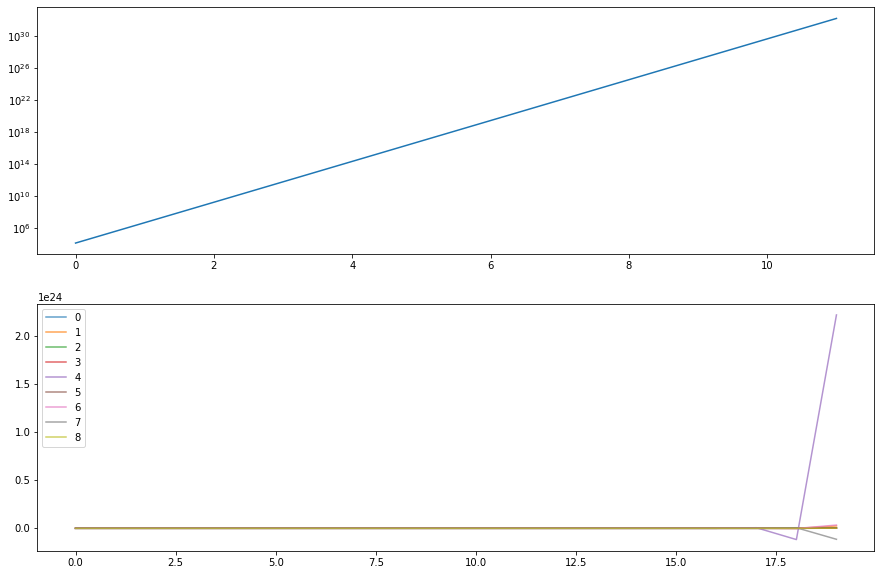

In [ ]:
fig, ax = plt.subplots(2,1,figsize = (15,10))
ax[0].plot(logger['loss'])
ax[0].set_yscale('log')
ax[1].plot(np.concatenate(logger['w'],-1).transpose(), alpha = .7)
ax[1].plot(np.concatenate(logger['b'],-1).transpose(), alpha = .7)
ax[1].legend(range(9))
# tax = ax[0].twinx()
# tax.plot(*logger['w'].transpose())

In [ ]:
X.corrwith(Y)

MedInc        0.688075
HouseAge      0.105623
AveRooms      0.151948
AveBedrms    -0.046701
Population   -0.024650
AveOccup     -0.023737
Latitude     -0.144160
Longitude    -0.045967
dtype: float64

## 04-2. Update pytorch variable 

In [ ]:
learning_ratio = 3.0e-7

In [ ]:
torch_weight = torch.randn((X.shape[1],1), device = device, requires_grad = True)
torch_bias = torch.randn((1,), device = device, requires_grad = True)

In [ ]:
def torch_linear_combination(x,y,w,b):
    y_hat = x @ w + b
    mse_loss = ((y - y_hat) ** 2).mean()
    
    mse_loss.backward()
    
    with torch.no_grad():
        w = w - learning_ratio * w.grad
        b = b - learning_ratio * b.grad
    w.requires_grad = True
    b.requires_grad = True
    
    return mse_loss, w, b

In [ ]:
torch_X = torch.tensor(X.values, dtype = torch.float32, device = device)
torch_Y = torch.tensor(Y.values, dtype = torch.float32, device = device)

In [ ]:
logger = dict(
    loss = [],
    w = [],
    b = []
)
for n in tqdm(range(1000)):
    loss, torch_weight, torch_bias = torch_linear_combination( torch_X, torch_Y, torch_weight, torch_bias)
    logger['loss'].append(loss.detach().cpu().numpy())
    logger['w'].append(torch_weight.detach().cpu().numpy())
    logger['b'].append(torch_bias.detach().cpu().numpy())

100%|██████████| 1000/1000 [00:34<00:00, 28.95it/s]


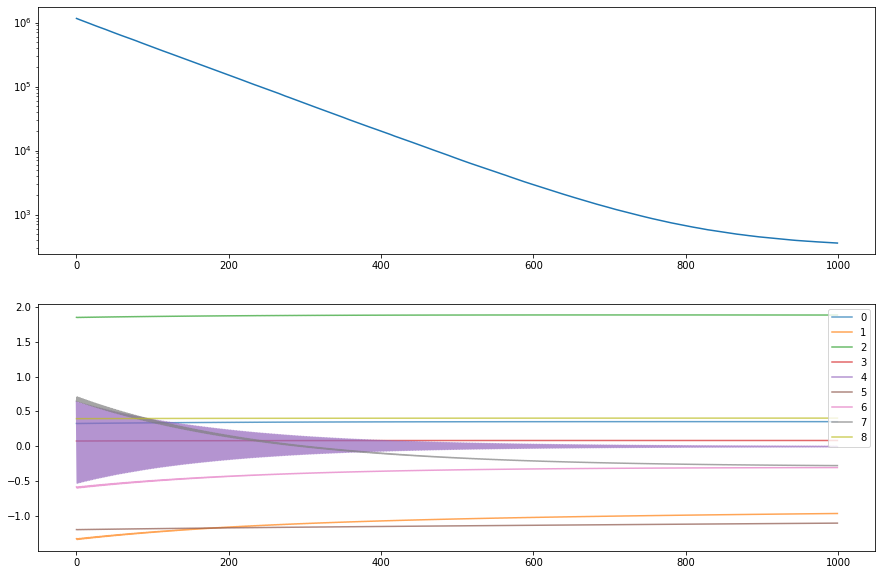

In [ ]:
fig, ax = plt.subplots(2,1,figsize = (15,10))
ax[0].plot(logger['loss'])
ax[0].set_yscale('log')
ax[1].plot(np.concatenate(logger['w'],-1).transpose(), alpha = .7)
ax[1].plot(np.concatenate(logger['b'],-1).transpose(), alpha = .7)
ax[1].legend(range(9))
# tax = ax[0].twinx()
# tax.plot(*logger['w'].transpose())

In [ ]:
X.corrwith(Y)

MedInc        0.688075
HouseAge      0.105623
AveRooms      0.151948
AveBedrms    -0.046701
Population   -0.024650
AveOccup     -0.023737
Latitude     -0.144160
Longitude    -0.045967
dtype: float64

# 05. Manual update to the linear layer with gradient descent

## 05-1. Update tensorflow layer

In [ ]:
class tf_linear(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, bias = True, initializer = None):
        super().__init__()
        
        if initializer == None:
            tf_initializer = tf.random_normal_initializer()
        else: 
            tf_initializer = initializer
        
        self.w = tf.Variable(tf_initializer((input_dim,output_dim)))
        
        self.bias = bias
        if self.bias:
            self.b = tf.Variable(tf_initializer((output_dim,)))
        
        
    @tf.function
    def __call__(self, x):
        if self.bias:
            return x @ self.w + self.b
        else:
            return x @ self.w

tf_relu = tf.keras.activations.relu

@tf.function
def tf_layers(x,y,l1,l2):
    with tf.GradientTape() as t:
        h1 = l1(x)
        a1 = tf_relu(h1)
        y_hat = l2(a1)
        mse_loss = tf.reduce_mean(tf.square(y - y_hat))
    dw1, db1, dw2, db2 = t.gradient(mse_loss, [l1.w, l1.b, l2.w, l2.b])
    l1.w.assign_sub(learning_ratio * dw1)
    l1.b.assign_sub(learning_ratio * db1)
    l2.w.assign_sub(learning_ratio * dw2)
    l2.b.assign_sub(learning_ratio * db2)
    return mse_loss

In [ ]:
tf_X, tf_Y = X.values.astype(np.float32), Y.values.reshape(-1,1).astype(np.float32)

In [ ]:
layer_01 = tf_linear(tf_X.shape[1],3)
layer_02 = tf_linear(3,1)

In [ ]:
logger = dict(
    loss = [],
    w1 = [],
    b1 = [],
    w2 = [],
    b2 = []
)
for n in tqdm(tf.range(1000)):
    loss = tf_layers( tf_X, tf_Y, layer_01, layer_02 )
    logger['loss'].append(loss.numpy())
    logger['w1'].append(layer_01.w.numpy())
    logger['b1'].append(layer_01.b.numpy())
    logger['w2'].append(layer_02.w.numpy())
    logger['b2'].append(layer_02.b.numpy())

100%|██████████| 1000/1000 [00:01<00:00, 640.34it/s]


In [ ]:
stack_w1 = np.stack(logger['w1'],0)
stack_b1 = np.stack(logger['b1'],0)

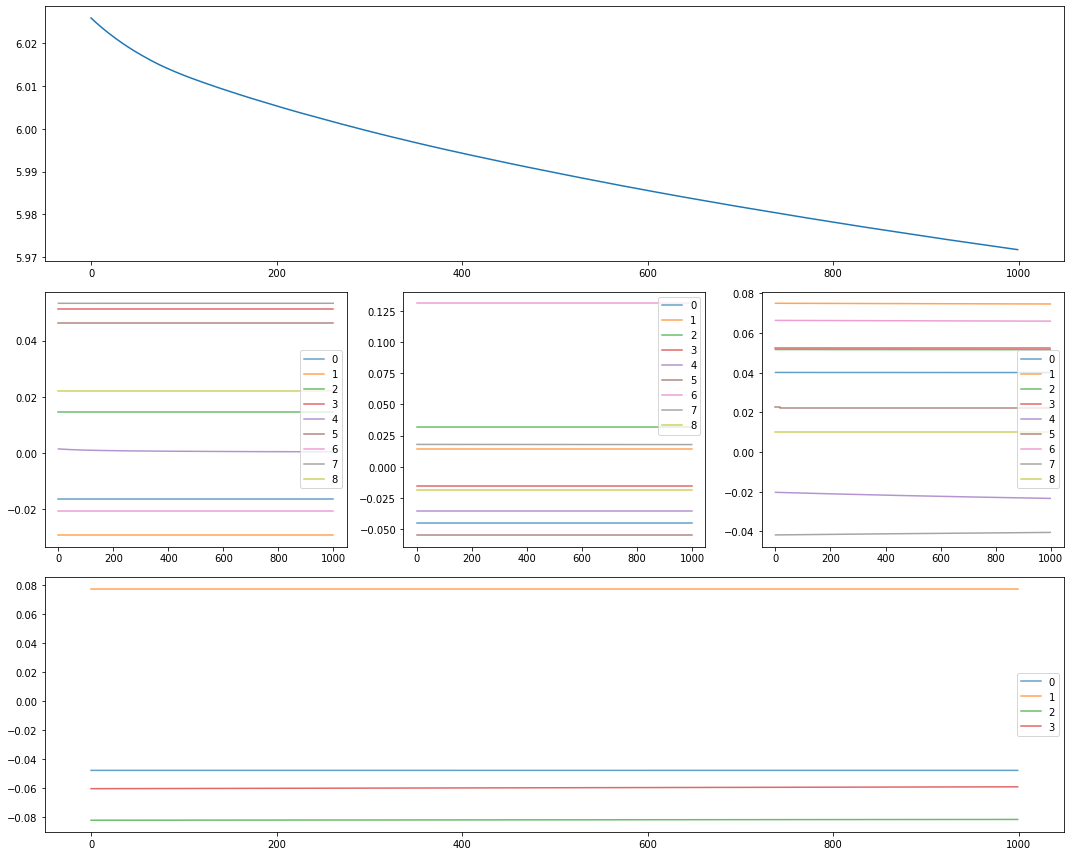

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize = (15,12))

gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
axbig.plot(logger['loss'])
# axbig.set_yscale('log')

for n in range(3):
    axs[1][n].plot(stack_w1[:,:,n], alpha = .7)
    axs[1][n].plot(stack_b1[:,n], alpha = .7)
    axs[1][n].legend(range(9))


gs = axs[0, 0].get_gridspec()
for ax in axs[2, :]:
    ax.remove()
axbig = fig.add_subplot(gs[2, :])
axbig.plot(np.concatenate(logger['w2'],-1).transpose(), alpha = .7)
axbig.plot(np.concatenate(logger['b2'],-1).transpose(), alpha = .7)
axbig.legend(range(9))



fig.tight_layout()

plt.show()


## 05-2. Update torch module

In [ ]:
class torch_linear(torch.nn.Module):
    def __init__(self, input_dim, output_dim, bias = True):
        super().__init__()
        self.w = torch.nn.Parameter(
            torch.nn.init.trunc_normal_(torch.empty(input_dim, output_dim))
        )
        
        self.bias = bias
        if self.bias:
            self.b = torch.nn.Parameter(
                torch.nn.init.trunc_normal_(torch.empty(output_dim,))
            )
        
    def forward(self, x):
        if self.bias:
            return x @ self.w + self.b
        else:
            return x @ self.w

def torch_linear_combination(x,y,l1,l2):
    h1 = l1(x)
    a1 = torch_relu(h1)
    o = l2(a1)
    
    mse_loss = ((y - o)**2).mean()
    
    mse_loss.backward()
    
    with torch.no_grad():
        for w in list(l1.parameters()) + list(l2.parameters()):
            w -= learning_ratio * w.grad
            
    return mse_loss

torch_relu = torch.nn.ReLU()

In [ ]:
torch_X = torch.tensor(X.values, dtype = torch.float32, device = device)
torch_Y = torch.tensor(Y.values, dtype = torch.float32, device = device)

learning_ratio = 3.0e-7

torch_linear_01 = torch_linear(torch_X.shape[1], 3).to(device)
torch_linear_02 = torch_linear(3, 1).to(device)


In [ ]:
logger = dict(
    loss = [],
    w1 = [],
    b1 = [],
    w2 = [],
    b2 = []
)
for n in tqdm(range(1000)):
    loss = torch_linear_combination(torch_X,torch_Y, torch_linear_01, torch_linear_02)
    logger['loss'].append(loss.detach().cpu().numpy())
    logger['w1'].append(torch_linear_01.w.detach().cpu().numpy())
    logger['b1'].append(torch_linear_01.b.detach().cpu().numpy())
    logger['w2'].append(torch_linear_02.w.detach().cpu().numpy())
    logger['b2'].append(torch_linear_02.b.detach().cpu().numpy())
    

100%|██████████| 1000/1000 [00:34<00:00, 28.86it/s]


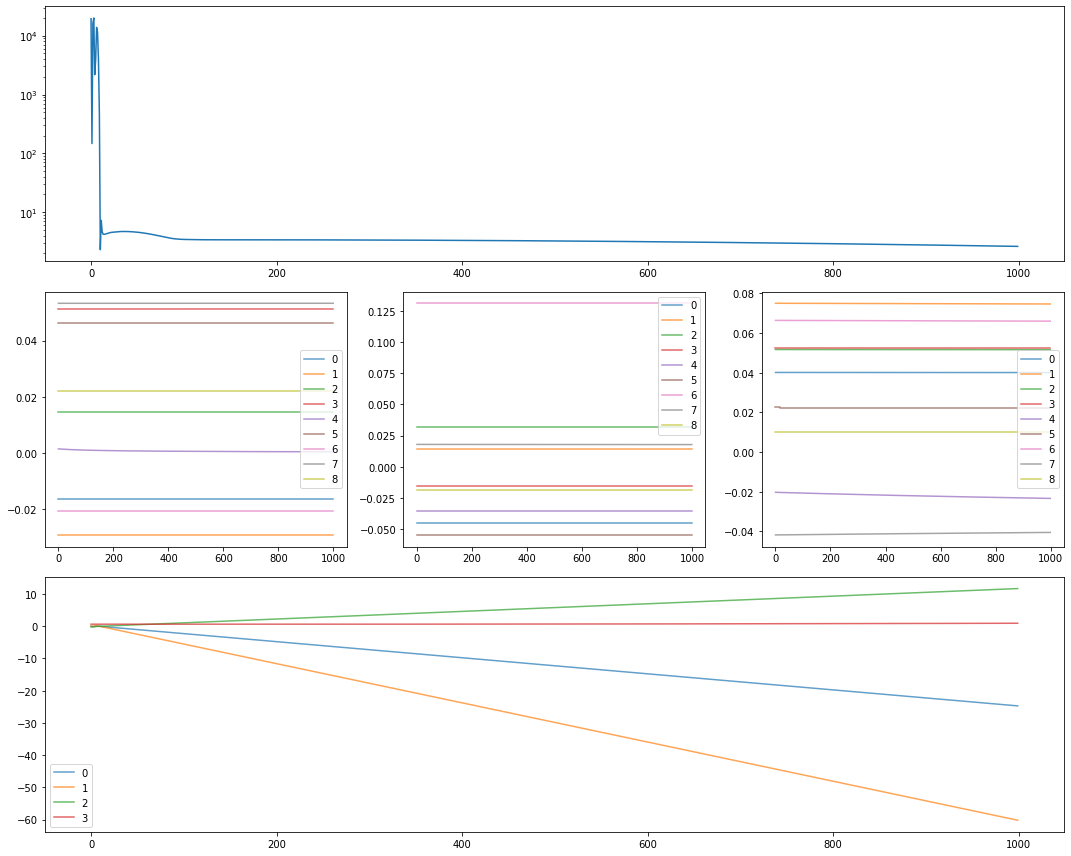

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize = (15,12))

gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
axbig.plot(logger['loss'])
axbig.set_yscale('log')

for n in range(3):
    axs[1][n].plot(stack_w1[:,:,n], alpha = .7)
    axs[1][n].plot(stack_b1[:,n], alpha = .7)
    axs[1][n].legend(range(9))


gs = axs[0, 0].get_gridspec()
for ax in axs[2, :]:
    ax.remove()
axbig = fig.add_subplot(gs[2, :])
axbig.plot(np.concatenate(logger['w2'],-1).transpose(), alpha = .7)
axbig.plot(np.concatenate(logger['b2'],-1).transpose(), alpha = .7)
axbig.legend(range(9))



fig.tight_layout()

plt.show()


In [ ]:

def torch_linear_combination(x,y,l1,l2):
    h1 = l1(x)
    a1 = torch_relu(h1)
    o = l2(a1)
    
    mse_loss = ((y - o)**2).mean()
    
    mse_loss.backward()
    
    with torch.no_grad():
        for w in list(l1.parameters()) + list(l2.parameters()):
            w -= learning_ratio * w.grad
            
    return mse_loss

In [ ]:
torch_linear_01.eval()

torch_linear()

# 06. High level API for Tensorflow & Pytorch

## 06-1. Using tensorflow API module

In [ ]:

from tqdm import tqdm


class tf_model_class(tf.keras.Model):
    def __init__(
        self, 
        dim_lists,
        activ,
        dropout,
    ):
        super().__init__()
        self.input_lists = dim_lists[:-1]
        self.output_lists = dim_lists[1:]
        
        self.linears = [tf_linear(i,o) for i,o in zip(self.input_lists, self.output_lists)]
        
        if dropout != 0:
            self.dropout = True
            self.dropout_layer = tf.keras.layers.Dropout(dropout)
        else:
            self.dropout = False
            
        self.activ = activ
        
    @tf.function
    def call(self, x, training = True):
        for l in self.linears[:-1]:
            x = l(x)
            x = self.activ(x)
            
            if self.dropout:
                x = self.dropout_layer(x, training)
        
                    
        return self.linears[-1](x)

class tf_trainer:
    def __init__(self, model, x, y, batch_size):
        self.model = model
        self.data = tf.data.Dataset.from_tensor_slices((x,y)).shuffle(batch_size * 10).batch(batch_size)
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        
    def __training_batch_step__(self, batch):
        x,y = batch
        with tf.GradientTape() as t:
            y_hat = self.model(x,training = True)
            loss = self.loss_fn(y, y_hat)
        grad = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        return loss

    def __training_epoch__(self, epoch_numb):
        loss_lists = []
        TQ = tqdm(self.data)
        for n, batch in enumerate(TQ,1):
            loss_lists.append(self.__training_batch_step__(batch))
            TQ.set_description_str(f'Epoch : {epoch_numb}')
            TQ.set_postfix_str(f'Loss : {sum(loss_lists) / n:.5}')
        return sum(loss_lists) / n
    
    def fit(self, loop_numb):
        history = dict(
            loss = []
        )
        for n in range(loop_numb):
            history['loss'].append(
                self.__training_epoch__(n)
            )
        return history

In [ ]:
tf_dicts = dict(
    dim_lists = (X.shape[1], 30, 10, 1),
    activ = tf.keras.activations.relu,
    dropout = .3,
)

In [ ]:
manual_tf_model = tf_model_class(**tf_dicts)


In [ ]:
trainer = tf_trainer(manual_tf_model, tf_X, tf_Y, 100)

Epoch : 19: 100%|██████████| 207/207 [00:01<00:00, 134.51it/s, Loss : 0.72871]


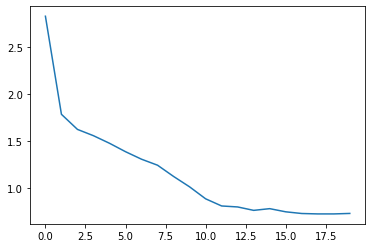

In [ ]:
plt.plot(trainer.fit(20)['loss'])

In [ ]:
tf_model = tf_model_class(**tf_dicts)

tf_model.build((2, X.shape[1]))
tf_model.summary()

Model: "tf_model_class"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_linear_2 (tf_linear)     multiple                  0 (unused)
                                                                 
 tf_linear_3 (tf_linear)     multiple                  0 (unused)
                                                                 
 tf_linear_4 (tf_linear)     multiple                  0 (unused)
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf_model.compile(
    tf.keras.optimizers.Adam(),
    tf.keras.losses.MeanSquaredError(),
)

In [ ]:
history = tf_model.fit(tf_X, tf_Y, 100, epochs = 20, verbose = 0)

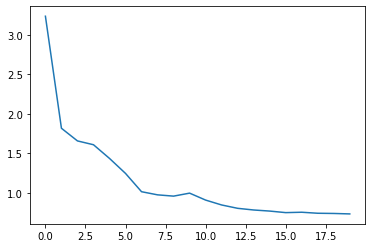

In [ ]:
plt.plot(history.history['loss'])

## 06-1. Using torch API module

In [ ]:

from tqdm import tqdm


class torch_model_class(torch.nn.Module):
    def __init__(
        self, 
        dim_lists,
        activ,
        dropout,
    ):
        super().__init__()
        self.input_lists = dim_lists[:-1]
        self.output_lists = dim_lists[1:]
        
        self.linears = torch.nn.ModuleList(
            [
                torch.nn.Linear(i,o) for i,o in zip(self.input_lists, self.output_lists)
            ]
        )
        
        if dropout != 0:
            self.dropout = True
            self.dropout_layer = torch.nn.Dropout(dropout)
        else:
            self.dropout = False
            
        self.activ = activ
        
    
    def forward(self, x):
        for l in self.linears[:-1]:
            x = l(x)
            x = self.activ(x)
            
            if self.dropout:
                x = self.dropout_layer(x)
        
                    
        return self.linears[-1](x)

    
    
class torch_trainer:
    def __init__(self, model, x, y, batch_size):
        self.model = model
        self.data = tf.data.Dataset.from_tensor_slices((x,y)).shuffle(batch_size * 10).batch(batch_size)
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        
    def __training_batch_step__(self, batch):
        x,y = batch
        with tf.GradientTape() as t:
            y_hat = self.model(x,training = True)
            loss = self.loss_fn(y, y_hat)
        grad = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        return loss

    def __training_epoch__(self, epoch_numb):
        loss_lists = []
        TQ = tqdm(self.data)
        for n, batch in enumerate(TQ,1):
            loss_lists.append(self.__training_batch_step__(batch))
            TQ.set_description_str(f'Epoch : {epoch_numb}')
            TQ.set_postfix_str(f'Loss : {sum(loss_lists) / n:.5}')
        return sum(loss_lists) / n
    
    def fit(self, loop_numb):
        history = dict(
            loss = []
        )
        for n in range(loop_numb):
            history['loss'].append(
                self.__training_epoch__(n)
            )
        return history

In [ ]:
manual_tf_model(tf_X, False)

<tf.Tensor: shape=(20640, 1), dtype=float32, numpy=
array([[3.6517997],
       [3.2459626],
       [3.5087564],
       ...,
       [1.3673903],
       [1.3673903],
       [1.3673903]], dtype=float32)>

In [ ]:
torch_dicts = dict(
    dim_lists = (X.shape[1], 30, 10, 1),
    activ = torch.nn.ReLU(),
    dropout = .3,
)

In [ ]:
manual_torch_model = torch_model_class(**torch_dicts)

In [ ]:
list(manual_torch_model.parameters())

[Parameter containing:
 tensor([[ 0.2514, -0.3185, -0.3016, -0.1177, -0.2238,  0.0614,  0.2289,  0.2998],
         [ 0.3480, -0.0552, -0.0918, -0.1623, -0.3294,  0.3516,  0.2894, -0.0963],
         [-0.1326,  0.3253,  0.0511,  0.0099,  0.2506, -0.1117, -0.0764, -0.1928],
         [ 0.2907, -0.2122,  0.2278, -0.2914, -0.0153, -0.1831,  0.0810, -0.0072],
         [-0.2016, -0.2333,  0.1902, -0.0982, -0.1778,  0.1890,  0.0293, -0.0772],
         [ 0.3424,  0.0298, -0.2402, -0.2035,  0.1459,  0.0976,  0.1630,  0.3179],
         [-0.2360,  0.1671,  0.2836, -0.1864,  0.0146, -0.0922, -0.1006, -0.2895],
         [-0.2796, -0.2812,  0.0782, -0.2535,  0.0253,  0.2476,  0.3435, -0.2490],
         [-0.1371, -0.3236, -0.1015, -0.2849, -0.0029, -0.2447, -0.1645, -0.3482],
         [-0.2095,  0.2838, -0.2530, -0.2900, -0.2999, -0.1368, -0.0843, -0.1067],
         [-0.0764,  0.0561, -0.0741, -0.2075,  0.0132, -0.2991,  0.1018,  0.2959],
         [-0.2389,  0.1858,  0.2354,  0.1356, -0.1798, -0.2039, 